### CH5.3.3 Image to Image RAG

In [ ]:
%pip install wikipedia

In [1]:
from dotenv import load_dotenv # 환경 변수 설정
load_dotenv()

True

In [ ]:
import os  # 파일 및 디렉토리 경로 관리를 위한 라이브러리

# 저장할 이미지 경로 설정
image_path = "./data_image/wikipedia_images"

# 이미지 저장 폴더 생성 (존재하지 않을 경우)
if not os.path.exists(image_path):
    os.makedirs(image_path)  # 하위 디렉토리까지 한 번에 생성
    
    
# 검색할 위키백과 페이지 목록
wiki_titles = [
    "Tesla Model S",
    "피아노",
    "현대자동차",
    "vincent van gogh",
    "쇼팽"
]
# 위키백과에서 페이지당 최대 다운로드할 이미지 개수 설정
MAX_IMAGES_PER_WIKI = 10

# 이미지 UUID 및 메타데이터 저장 딕셔너리 초기화
image_uuid = 0 # 이미지 고유 식별자(번호) 부여
image_metadata_dict = {} # 다운로드 한 이미지의 메타데이터 저장

import wikipedia  # 위키백과 페이지 정보를 가져오기 위한 라이브러리
import urllib.request  # 이미지 다운로드를 위한 라이브러리

# 위키백과에서 이미지 다운로드 및 저장
for title in wiki_titles:
    images_per_wiki = 0  # 해당 페이지에서 다운로드한 이미지 개수
    print(f"Processing Wikipedia page: {title}")

    try:
        # 위키백과 페이지 가져오기
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images  # 해당 페이지의 이미지 URL 목록 가져오기

        # 이미지 다운로드
        for url in list_img_urls:
            # 확장자가 JPG 또는 PNG인 경우만 다운로드
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1  # UUID 증가
                image_file_name = f"{title}_{url.split('/')[-1]}"  # 파일명 생성

                # 이미지 메타데이터 저장 (파일명 및 경로)
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": str(image_path / f"{image_uuid}.jpg"),
                }

                # 이미지 다운로드 및 저장
                urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")

                images_per_wiki += 1  # 다운로드한 이미지 개수 증가

                # 지정된 개수만큼만 이미지 다운로드 (기본값: 10개)
                if images_per_wiki >= MAX_IMAGES_PER_WIKI:
                    break

    except Exception as e:
        # 오류 발생 시 예외 처리 및 로그 출력
        print(f"Error: {e}")
        print(f"위키피디아에서 이미지를 찾을 수 없습니다.: {title}")
        continue

Tesla Model S
피아노
현대자동차
vincent van gogh
[Errno 22] Invalid argument: 'data_image\\wikipedia_images\\30.jpg'
No images found for Wikipedia page: vincent van gogh
쇼팽


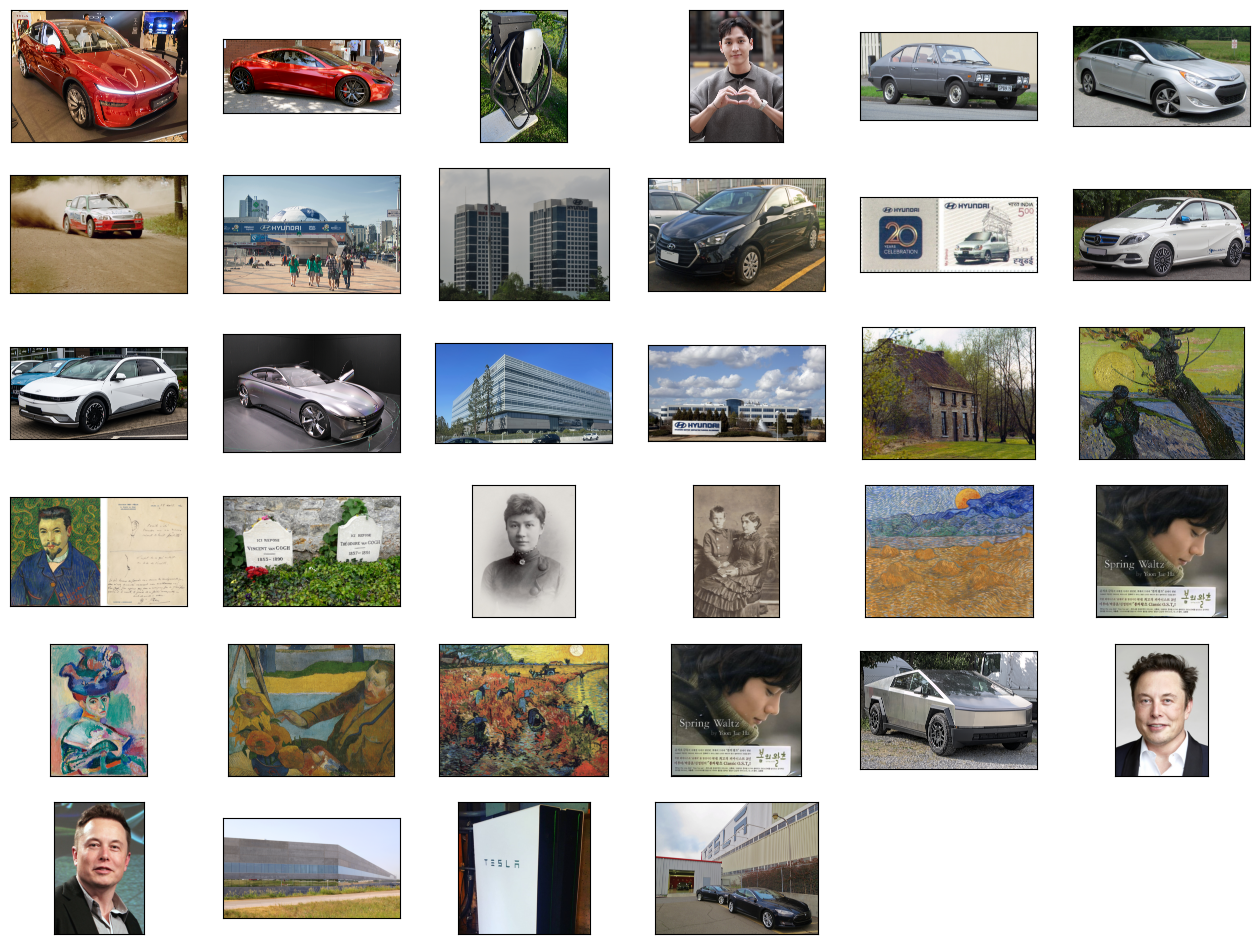

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./data_image/wikipedia_images"):
    image_paths.append(str(os.path.join("./data_image/wikipedia_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 12))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(6, 6, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 35:
                break


plot_images(image_paths)

In [3]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader("./data_image/wikipedia_images").load_data()
print('이미지의 개수 : ', len(documents))

이미지의 개수 :  34


In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # 손상된 이미지를 로드하도록 설정

from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
import qdrant_client

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="./index/ch05_3_3_qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [5]:
# Create the MultiModal index
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
index = MultiModalVectorStoreIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
)
index.storage_context.persist(persist_dir="./index/ch05_3_3_qdrant_img_db")

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\llama_index\vector_stores\qdrant\base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [6]:
from llama_index.core import load_index_from_storage
# 저장된 StorageContext 로드

storage_context = StorageContext.from_defaults(
    persist_dir="./index/ch05_3_3_qdrant_img_db",
    vector_store=text_store,
    image_store=image_store
)

# 저장된 인덱스 로드
index = load_index_from_storage(storage_context)

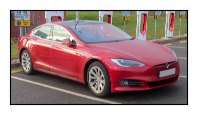

In [ ]:
# 입력할 이미지 확인
input_img_path = "./data_image/image_input/red_car.jpg"
plot_images([input_img_path])

Node ID: 7bac6851-7f8a-4744-aab0-5a55e6f67d59
Text:
Score:  0.805

Node ID: c1dd2dd3-af94-43ef-a545-142a3c723e55
Text:
Score:  0.800

Node ID: 52e0c33d-badf-438d-9ece-51c67b56afab
Text:
Score:  0.783

Node ID: 14289e3d-3b68-4f42-b2c2-ea2761674658
Text:
Score:  0.748



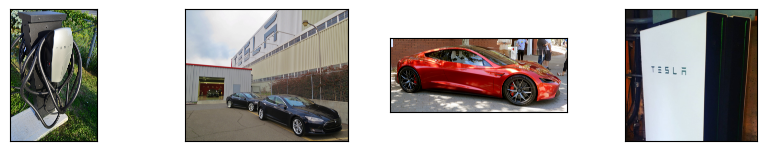

In [ ]:
# instantiate a retriever
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# get images semantically similar to our own
retrieval_results = retriever_engine.image_to_image_retrieve(input_img_path)

# 검색 결과 출력하기
retrieved_images = []
for res in retrieval_results:
    print(res)
    retrieved_images.append(res.node.metadata["file_path"])

# display the images we found
plot_images(retrieved_images)

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", max_new_tokens=1500
)

qa_tmpl_str = (
    "주어진 이미지에 따라 질문에 응답하시오.\n"
    "Prompt: {query_str}\n"
    "Response: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, 
    image_qa_template=qa_tmpl,
    similarity_top_k=3, 
    image_similarity_top_k=4
)

query_str = "제가 입력한 그림과 검색 된 그림에 대해 설명해주시길 바랍니다"
response = query_engine.image_query(input_img_path, query_str)
print(response)

주어진 이미지들은 테슬라와 관련된 다양한 제품과 시설을 보여줍니다.

1. **첫 번째 이미지**: 테슬라의 전기차 충전기입니다. 이 충전기는 전기차를 충전하는 데 사용되며, 주로 주차장이나 가정에서 볼 수 있습니다.

2. **두 번째 이미지**: 테슬라 공장 외부와 테슬라 차량들이 보입니다. 공장 건물에는 테슬라 로고가 크게 표시되어 있으며, 주차된 차량들은 테슬라의 전기차 모델입니다.

3. **세 번째 이미지**: 테슬라의 스포츠카 모델입니다. 이 차량은 유려한 디자인과 고성능을 특징으로 하며, 테슬라의 기술력을 보여줍니다.

4. **네 번째 이미지**: 테슬라의 에너지 저장 장치인 파워월(Powerwall)입니다. 이 장치는 가정이나 사업장에서 에너지를 저장하고 관리하는 데 사용됩니다.

이 이미지들은 테슬라의 다양한 제품과 기술을 잘 보여주고 있습니다.
